# Feature importance

This notebook investigates the development of the importance of feature types from earlier to later layers.
For the top 5 Filters, the KS Scores for the 5 different Feature types (FFT,FFTc,Phase,Phasec,Mean,MeanC,Power) are computed. After that the development of mean KS Scores and maximum KS Score is presented

In [1]:
import numpy as np
import scipy
import random
from braindecode.veganlasagne.layer_util import print_layers

import os
from numpy.random import RandomState

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled, cuDNN 5005)


In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [3]:
import convvisual.receptive_field.receptive_field as receptive_field
import convvisual.analysis.analysis as analysis
import convvisual.analysis.utils as utils
import convvisual.analysis.plot as plot

/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'

In [6]:
rng = RandomState(98787)

In [7]:
KS_means = np.zeros((5,5,7))
KS_maxs = np.zeros((5,5,7))

In [8]:
import os
cl = 0
if "EEGCLASS" in os.environ:
    cl = int(os.environ['EEGCLASS'])-1
n_class_inputs = 50
max_baseline_inputs = 5000 # Number of signal windows used for baseline
wins_per_input = 3

In [9]:
layers = [4,10,16,22,28]
feature_funcs = (analysis.get_frequency,analysis.get_frequency_change,analysis.get_offset,analysis.get_offset_change,analysis.get_phase_change,analysis.get_bandpower)
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits200_nFilters5'))
n_chans = RF_Data.n_chans
sampling_rate = RF_Data.sampling_rate
    
for i,l in enumerate(layers):
    print l
    RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_FilterDiff_nUnits200_nFilters5'),l,cl)
        
    c = False
    for j,filt in enumerate(RF_Result.max_filters):
        X_RF_cropped = utils.get_RF(RF_Result,j,n_chans)[:n_class_inputs]
        
        if not c:
            X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]
            c = True
            
        
        features_class = list(utils.get_feature_vals(X_RF_cropped,feature_funcs,sampling_rate=sampling_rate))
        features_class.append(np.angle(features_class[0])[:,:,1:]) #cut off phase 0Hz
        features_class[0] = analysis.real_frequency(features_class[0])
        
        features_base = list(utils.get_feature_vals(X_baseline,feature_funcs,sampling_rate=sampling_rate))
        features_base.append(np.angle(features_base[0])[:,:,1:]) #cut off phase 0Hz
        features_base[0] = analysis.real_frequency(features_base[0])
        
        for k in range(KS_means.shape[2]):
            feat_class = utils.create_flattened_featurearr([features_class[k]],shape=(features_class[0].shape[0],-1))
            feat_base = utils.create_flattened_featurearr([features_base[k]],shape=(features_base[0].shape[0],-1))
            feat_diff,_ = utils.feat_diff_KS(feat_class,feat_base)
            
            KS_means[i,j,k] = np.mean(feat_diff)
            KS_maxs[i,j,k] = np.max(feat_diff)

4
10


KeyboardInterrupt: 

### KS Score development

The first plot shows the development of the mean KS Score for each Feature type over Layers.

The second plot shows the development of the maximum KS Score for each Feature type.

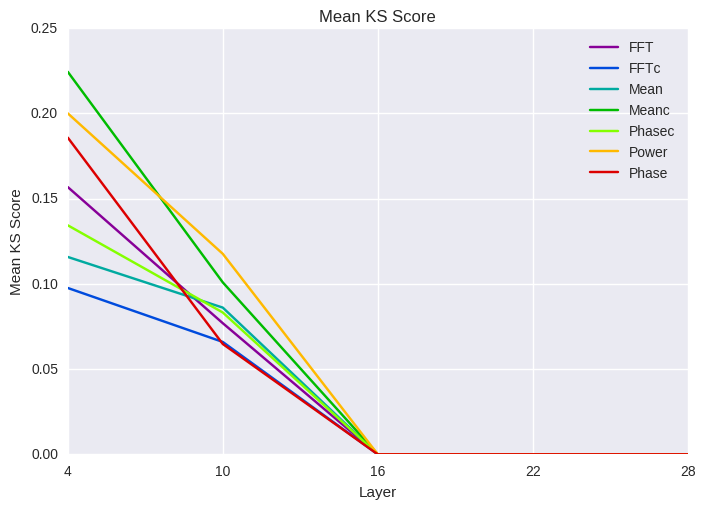

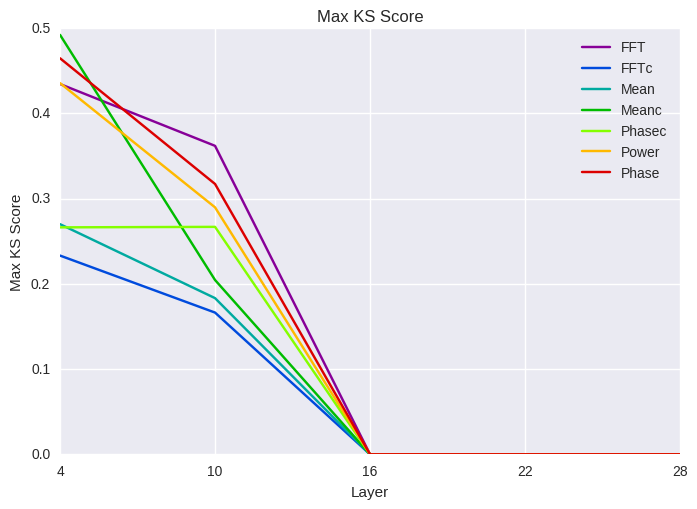

In [39]:
plt.gca().set_color_cycle(plt.cm.spectral(np.linspace(0.1,0.9,7)))
plt.plot(KS_means.mean(axis=1))
plt.legend(['FFT','FFTc','Mean','Meanc','Phasec','Power','Phase'])
plt.xticks(range(5),layers)
plt.xlabel('Layer')
plt.ylabel('Mean KS Score')
plt.title('Mean KS Score')
plt.show()

plt.gca().set_color_cycle(plt.cm.spectral(np.linspace(0.1,0.9,7)))
plt.plot(KS_maxs.mean(axis=1))
plt.legend(['FFT','FFTc','Mean','Meanc','Phasec','Power','Phase'])
plt.xticks(range(5),layers)
plt.xlabel('Layer')
plt.ylabel('Max KS Score')
plt.title('Max KS Score')
plt.show()